# Apache Spark: Deeper Analysis

## Introduction

In this notebook I will perform a deeper analysis of the data in the San Francisco Taxi Trip data set. I will concentrate on trip times, distances, and fares.

## Setup

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql.functions import row_number

import matplotlib.pyplot as plt
%matplotlib inline

spark = (SparkSession
    .builder
    .appName('test')
    .getOrCreate())

# The following sets up the ability to output a nicely formatted table.
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)
spark.conf.set("spark.sql.repl.eagerEval.maxNumRows", 100)

## Load the Data

The following cell reads a Parquet file into a Spark DataFrame and then prints out the schema of the DataFrame. This notebook uses the clean version of the parquet file that was created in the Initial Analysis notebook.

In [2]:
df = spark.read.parquet('/home/jovyan/work/Taxi_Trips_SF_20250621_clean.parquet')

df.printSchema()

root
 |-- vehicle_placard_number: string (nullable = true)
 |-- driver_id: string (nullable = true)
 |-- start_time_local: timestamp (nullable = true)
 |-- end_time_local: timestamp (nullable = true)
 |-- pickup_location_latitude: double (nullable = true)
 |-- pickup_location_longitude: double (nullable = true)
 |-- pickup_location: string (nullable = true)
 |-- dropoff_location_latitude: double (nullable = true)
 |-- dropoff_location_longitude: double (nullable = true)
 |-- dropoff_location: string (nullable = true)
 |-- hail_type: string (nullable = true)
 |-- paratransit: integer (nullable = true)
 |-- sfo_pickup: integer (nullable = true)
 |-- qa_flags: string (nullable = true)
 |-- fare_type: string (nullable = true)
 |-- meter_fare_amount: double (nullable = true)
 |-- upfront_pricing: double (nullable = true)
 |-- promo_rate: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- sf_exit_fee: double (nullable = true)
 |-- other_fees: double (nullable = true)
 |-- tip

## Create a DataFrame with only the columns that will be used

Since there are a limited number of columns that will be used in the analysis let's create a DataFrame that only contains those columns and do any transformations to the data up front, so we won't have to do it every time.

In [3]:
miles_divisor: float = 1609.344

df.createOrReplaceTempView('rides')

# Note: there are trips with negative fare times. Excluding those.
dfs = spark.sql(f"""
select   trunc(to_timestamp(start_time_local, 'y/M/d h:m:s a'), 'month') month
         ,total_fare_amount
         ,fare_time_milliseconds
         ,fare_time_milliseconds / 1000 / 60 as fare_time_minutes
         ,trip_distance_meters
         ,trip_distance_meters / {miles_divisor} as trip_distance_miles
         ,sfo_pickup
         ,driver_id
         ,vehicle_placard_number
from     rides
where    fare_time_milliseconds >= 0 -- and (fare_time_milliseconds / 1000 / 60) < 240;
""")

# Now let's cache the data

dfs.cache()

dfs.printSchema()

root
 |-- month: date (nullable = true)
 |-- total_fare_amount: double (nullable = true)
 |-- fare_time_milliseconds: integer (nullable = true)
 |-- fare_time_minutes: double (nullable = true)
 |-- trip_distance_meters: double (nullable = true)
 |-- trip_distance_miles: double (nullable = true)
 |-- sfo_pickup: integer (nullable = true)
 |-- driver_id: string (nullable = true)
 |-- vehicle_placard_number: string (nullable = true)



## Create a Temp View on the DataFrame

The createOrReplaceTempView() method to create a view on the DataFrame that can be used in SparkSQL to refer to the DataFrame.

In [4]:
dfs.createOrReplaceTempView('rides')

In [5]:
spark.sql("""
select    count(1) as count
from      rides;
""").limit(10) # The limit will cause this to print out nicely formatted.

count
4128965


## Fare Amount

Let's calculate the mininimum, median, ave#rage. and a maximum fare amount for the dataset and then by month.

In [6]:
df1 = spark.sql( """
select min(total_fare_amount) as min_amount
       ,median(total_fare_amount) as median_amount
       ,round(avg(total_fare_amount), 2) as avg_amount
       ,max(total_fare_amount) as max_amount
from   rides;
""")

df1.limit(10)

min_amount,median_amount,avg_amount,max_amount
0.0,17.15,29.16,55552.25


In [7]:
df2 = spark.sql( """
select   month
         ,min(total_fare_amount) as min_amount
         ,median(total_fare_amount) as median_amount
         ,round(avg(total_fare_amount), 2) as avg_amount
         ,max(total_fare_amount) as max_amount
from     rides
group by month
order by month;
""")

df2.limit(10)

month,min_amount,median_amount,avg_amount,max_amount
2022-12-01,0.0,17.15,29.6,1131.25
2023-01-01,0.0,17.8,31.19,3989.15
2023-02-01,0.0,17.15,30.27,55552.25
2023-03-01,0.0,17.8,30.79,4013.9
2023-04-01,0.0,17.8,30.0,1605.75
2023-05-01,0.0,17.8,30.34,1224.2
2023-06-01,0.0,17.5,30.22,2419.55
2023-07-01,0.0,17.8,30.51,1176.1
2023-08-01,0.0,17.15,29.93,2507.3
2023-09-01,0.0,17.81,30.73,1395.15


### Note:

It seems that people in San Francisco take some really expensive cab rides. In reality, I think this is probably test data.

## Fare Distance

Now let's due the same thing, but with the distance. The distance is in meters, so first we will look at it in meters, then we will convert it to miles.

In [8]:
df3 = spark.sql( """
select min(trip_distance_meters) as min_distance
       ,round(median(trip_distance_meters), 2) as median_distance
       ,round(avg(trip_distance_meters), 2) as avg_distance
       ,max(trip_distance_meters) as max_distance
from   rides;
""")

df3.limit(10)

min_distance,median_distance,avg_distance,max_distance
0.0,4184.29,9728.99,1165486.9


In [9]:
df4 = spark.sql( """
select month
       ,min(trip_distance_meters) as min_distance
       ,round(median(trip_distance_meters), 2) as median_distance
       ,round(avg(trip_distance_meters), 2) as avg_distance
       ,max(trip_distance_meters) as max_distance
from   rides
group by month
order by month;
""")

df4.limit(10)

month,min_distance,median_distance,avg_distance,max_distance
2022-12-01,0.0,4184.3,9903.68,429694.8
2023-01-01,0.0,4506.16,10593.73,440316.5
2023-02-01,0.0,4184.3,10149.07,829777.8
2023-03-01,0.0,4506.2,10465.37,1058626.5
2023-04-01,0.0,4521.29,10249.52,554258.1
2023-05-01,0.0,4553.47,10401.23,598676.0
2023-06-01,0.0,4506.2,10331.97,1165486.9
2023-07-01,0.0,4506.2,10436.29,566811.0
2023-08-01,0.0,4345.2,10123.31,726296.9
2023-09-01,0.0,4506.2,10449.71,652267.1


### Miles

In [10]:
df5 = spark.sql("""
select   round(min(trip_distance_miles), 2) as min_distance
         ,round(median(trip_distance_miles), 2) as median_distance
         ,round(avg(trip_distance_miles), 2) as avg_distance
         ,round(max(trip_distance_miles), 2) as max_distance
from     rides;
""")

df5.limit(10)

min_distance,median_distance,avg_distance,max_distance
0.0,2.6,6.05,724.2


In [11]:
df6 = spark.sql("""
select month
       ,round(min(trip_distance_miles), 2) as min_distance
       ,round(median(trip_distance_miles), 2) as median_distance
       ,round(avg(trip_distance_miles), 2) as avg_distance
       ,round(max(trip_distance_miles), 2) as max_distance
from   rides
group by month
order by month;
""")

df6.limit(10)

month,min_distance,median_distance,avg_distance,max_distance
2022-12-01,0.0,2.6,6.15,267.0
2023-01-01,0.0,2.8,6.58,273.6
2023-02-01,0.0,2.6,6.31,515.6
2023-03-01,0.0,2.8,6.5,657.8
2023-04-01,0.0,2.81,6.37,344.4
2023-05-01,0.0,2.83,6.46,372.0
2023-06-01,0.0,2.8,6.42,724.2
2023-07-01,0.0,2.8,6.48,352.2
2023-08-01,0.0,2.7,6.29,451.3
2023-09-01,0.0,2.8,6.49,405.3


## Fare Time

Now let's look at how long these trips took.

In [12]:
df7 = spark.sql("""
select   round(min(fare_time_milliseconds), 2) as min_time
         ,round(median(fare_time_milliseconds), 2) as median_time
         ,round(avg(fare_time_milliseconds), 2) as avg_time
         ,round(max(fare_time_milliseconds), 2) as max_time
from     rides;
""")

df7.limit(10)

min_time,median_time,avg_time,max_time
0,590602.0,1261752.33,2114160592


In [13]:
df8 = spark.sql("""
select   month
         ,round(min(fare_time_milliseconds), 2) as min_time
         ,round(median(fare_time_milliseconds), 2) as median_time
         ,round(avg(fare_time_milliseconds), 2) as avg_time
         ,round(max(fare_time_milliseconds), 2) as max_time
from     rides
group by month
order by month;
""")

df8.limit(10)

month,min_time,median_time,avg_time,max_time
2022-12-01,0,633692.5,848397.11,463847665
2023-01-01,0,676269.0,884829.87,239690898
2023-02-01,0,651000.0,868729.69,1262603745
2023-03-01,0,632370.0,838574.95,224172633
2023-04-01,0,570983.0,771352.03,237565246
2023-05-01,0,583804.0,804657.49,344215485
2023-06-01,0,565681.0,797444.76,316862037
2023-07-01,0,571305.0,797702.93,241084362
2023-08-01,0,551061.0,769072.68,149564904
2023-09-01,0,563036.0,775382.86,177106505


### Minutes

In [14]:
df9 = spark.sql("""
select   round(min(fare_time_minutes), 2) as min_time
         ,round(median(fare_time_minutes), 2) as median_time
         ,round(avg(fare_time_minutes), 2) as avg_time
         ,round(max(fare_time_minutes), 2) as max_time
from     rides;
""")

df9.limit(10)

min_time,median_time,avg_time,max_time
0.0,9.84,21.03,35236.01


In [15]:
df10 = spark.sql("""
select   month
         ,round(min(fare_time_minutes), 2) as min_time
         ,round(median(fare_time_minutes), 2) as median_time
         ,round(avg(fare_time_minutes), 2) as avg_time
         ,round(max(fare_time_minutes), 2) as max_time
from     rides
group by month
order by month;
""")

df10.limit(10)

month,min_time,median_time,avg_time,max_time
2022-12-01,0.0,10.56,14.14,7730.79
2023-01-01,0.0,11.27,14.75,3994.85
2023-02-01,0.0,10.85,14.48,21043.4
2023-03-01,0.0,10.54,13.98,3736.21
2023-04-01,0.0,9.52,12.86,3959.42
2023-05-01,0.0,9.73,13.41,5736.92
2023-06-01,0.0,9.43,13.29,5281.03
2023-07-01,0.0,9.52,13.3,4018.07
2023-08-01,0.0,9.18,12.82,2492.75
2023-09-01,0.0,9.38,12.92,2951.78


## Look at those trips originating at SFO vs. those that don't

In [16]:
df12 = spark.sql("""
with sfo as (
select   *
from     rides
where    sfo_pickup = 1
),
nonsfo as (
select    *
from      rides
where     sfo_pickup = 0
),
total as (
select   *
from     rides
),
cnts as (
select    (select count(1) from sfo) sfo
          , (select count(1) from nonsfo) nonsfo
          , (select count(1) from total) total
)
select   sfo
         , nonsfo
         , total
         , round((sfo / total) * 100, 2) sfo_percent
         , round((nonsfo / total) * 100, 2) nonsfo_percent
from     cnts
""")

df12.limit(10)

sfo,nonsfo,total,sfo_percent,nonsfo_percent
1007044,3121921,4128965,24.39,75.61


## Top Drivers and Top Vehicles

Look at the top drivers by total trip time and total miles driven and the top vehicles by total miles driven.

In [17]:
df16 = spark.sql("""
select   driver_id, round(sum(fare_time_minutes), 2) as total_trip_time
from     rides
group by driver_id
order by total_trip_time desc;
""")

df16.limit(10)

driver_id,total_trip_time
-,1094813.63
F-4919,458960.04
B-6401,458665.04
V-9330,410371.34
A-9919,377851.54
F-9617,369182.91
C-8494,363182.83
U-7473,343043.12
E-4134,336702.26
E-6625,332399.3


In [18]:
df17  = spark.sql("""
select   driver_id, round(sum(trip_distance_miles), 2) as trip_distance_miles
from     rides
group by driver_id
order by trip_distance_miles desc;
""")

df17.limit(10)

driver_id,trip_distance_miles
-,458162.35
U-7473,95415.4
B-6401,93690.8
C-8155,72712.8
A-4301,71316.52
F-9617,70985.5
B-9981,70238.85
F-8012,68399.6
N-7318,65937.95
Y-5184,65700.91


### Top N (10) Drivers by Distance by Month

In [19]:
df19 = spark.sql("""
with x as (
select   month, driver_id, round(sum(trip_distance_miles), 0) trip_miles
from     rides
group by month, driver_id
order by month, trip_miles desc
)
select   month, driver_id, trip_miles
from (select   *, row_number() over (partition by month order by trip_miles desc) rn
from     x) tmp
where    rn <= 10;
""")

df19.limit(50)

month,driver_id,trip_miles
2022-12-01,-,18573.0
2022-12-01,A-4301,5905.0
2022-12-01,A-7414,4927.0
2022-12-01,B-0575,4249.0
2022-12-01,F-5183,4182.0
2022-12-01,B-6401,3974.0
2022-12-01,C-8155,3923.0
2022-12-01,F-9617,3814.0
2022-12-01,B-3671,3707.0
2022-12-01,F-9314,3568.0


In [20]:
df18 = spark.sql("""
select   vehicle_placard_number, round(sum(fare_time_minutes), 2) as total_trip_time
from     rides
group by vehicle_placard_number
order by total_trip_time desc;
""")

df18.limit(10)

vehicle_placard_number,total_trip_time
1273,507417.77
1410,499777.88
1405,497091.58
0134,466708.3
0732,465961.48
1156,419821.62
0784,419599.12
0454,390736.21
1376,389043.23
0251,377331.29


In [21]:
df18 = spark.sql("""
select   vehicle_placard_number, round(sum(trip_distance_miles), 2) as trip_distance_miles
from     rides
group by vehicle_placard_number
order by trip_distance_miles desc;
""")

df18.limit(10)

vehicle_placard_number,trip_distance_miles
0732,97178.0
9010,93663.8
1410,88764.1
0134,76727.0
1555,75354.9
0371,74055.4
1180,73626.4
1420,73510.7
1273,71949.1
0768,70238.85


## Looking at Outliers

This data set appears to have many outliers. In this section I will try to determine which are outl

### Excessively Long Rides

First, let's look at a sample of records for excessively long rides, which I am defining as those rides that take more than 240 minutes (4 hours).

In [22]:
df13 = spark.sql("""
select   *
from     rides
where    fare_time_minutes > 240
order by fare_time_minutes desc;
""")

df13.limit(100)

month,total_fare_amount,fare_time_milliseconds,fare_time_minutes,trip_distance_meters,trip_distance_miles,sfo_pickup,driver_id,vehicle_placard_number
2024-02-01,117.55,2114160592,35236.00986666667,53269.0,33.099822039290544,1,D-6085,2166
2023-10-01,0.0,1545819105,25763.65175,20116.8,12.5,0,F-7292,9036
2023-02-01,48.2,1262603745,21043.395750000003,14806.0,9.200021872265966,0,C-5989,1130
2022-12-01,0.0,463847665,7730.794416666667,0.0,0.0,0,A-8439,0111
2024-05-01,0.0,364013371,6066.889516666666,3862.4,2.3999840928974785,0,F-7292,9036
2023-10-01,0.0,348253216,5804.220266666667,0.0,0.0,0,F-0546,0950
2023-05-01,4.15,344215485,5736.92475,0.0,0.0,0,A-4916,0017
2024-05-01,0.0,338813371,5646.889516666666,0.0,0.0,0,F-7292,9036
2023-06-01,0.0,316862037,5281.03395,0.0,0.0,0,F-0707,0451
2023-11-01,0.0,311217002,5186.950033333333,0.0,0.0,0,A-4523,1273


In [23]:
df14 = spark.sql("""
select   round(fare_time_minutes / 60, 0) trip_hour, count(1) trip_count
from     rides
where    round(fare_time_minutes / 60, 0) >= 2
group by trip_hour
order by trip_hour;
""")

df14.limit(100)

trip_hour,trip_count
2.0,15466
3.0,4478
4.0,1992
5.0,919
6.0,460
7.0,65307
8.0,9736
9.0,1118
10.0,405
11.0,210


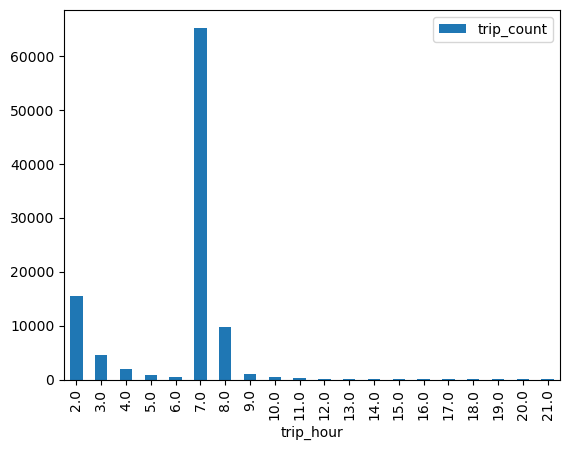

In [24]:
df14 = df14.limit(20).toPandas()
df14.plot(kind="bar", x="trip_hour", y="trip_count")
plt.show()

In [25]:
df15 = spark.sql("""
with stats as (
select   avg(fare_time_minutes) avg_ftm, std(fare_time_minutes) std_ftm
from     rides
where    fare_time_milliseconds > 0
)
select   avg_ftm
         , std_ftm
         , avg_ftm + std_ftm one_std
         , avg_ftm + 2*std_ftm two_std
         , avg_ftm + 3*std_ftm three_std
from     stats;
""")

df15.limit(10)

avg_ftm,std_ftm,one_std,two_std,three_std
23.196721287420274,71.74252398062887,94.93924526804915,166.68176924867802,238.4242932293069


## Conclusion

If you have SQL experience, SparkSQL makes it easy to manipulate data. One thing that I noticed with this data set is that it has some data that look like anamolies. In the next notebook, I will be using SparkML for anamoly detection and time series predictions.